In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

<IPython.core.display.Javascript object>

# Define methods

In [3]:
def read_face_data_record(record: dict) -> dict:
    return {
        "is_face_detected": record["is_face_detected"],
        "angry": record["emotions"]["angry"],
        "disgust": record["emotions"]["disgust"],
        "fear": record["emotions"]["fear"],
        "happy": record["emotions"]["happy"],
        "sad": record["emotions"]["sad"],
        "neutral": record["emotions"]["neutral"],
        "head_turn": record["head_turn"],
        "eyes_closed": record["eyes_closed"],
    }

<IPython.core.display.Javascript object>

In [4]:
def output_metric(metric: str, dfs: list, smooth_span=1) -> None:
    f, ax = plt.subplots(figsize=(14, 3))
    for df in dfs:
        ax.plot(df[metric].ewm(span=smooth_span).mean())

<IPython.core.display.Javascript object>

In [5]:
def get_signal_df_list(data_files: list) -> list:
    face_data_signals = []
    for data_file in data_files:
        with open(data_file) as f:
            face_data = pd.DataFrame(
                [read_face_data_record(json.loads(line)) for line in f]
            )
        face_data_signals.append(face_data)
    return face_data_signals

<IPython.core.display.Javascript object>

In [6]:
def merge_on_metric(
    face_data_signals: list,
    attr_name: str,
    column_names: list,
    smoothing_window: int,
    min_len: int,
) -> pd.DataFrame:
    res_df = (
        pd.DataFrame(
            [face_data[attr_name][:min_len] for face_data in face_data_signals],
        )
        .T.ewm(span=smoothing_window)
        .mean()
    )
    res_df.columns = column_names
    return res_df

<IPython.core.display.Javascript object>

In [7]:
def crosscorr(data_x, data_y, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    data_x = pd.Series(data_x)
    data_y = pd.Series(data_y)

    if wrap:
        shifted_y = data_y.shift(lag)
        shifted_y.iloc[:lag] = data_y.iloc[-lag:].values
        return data_x.corr(shifted_y)
    else:
        return data_x.corr(data_y.shift(lag))

<IPython.core.display.Javascript object>

In [8]:
def get_shifted_correlations(data_1, data_2, shift_window: int):
    shift_ranges = range(-shift_window, shift_window)

    rs = [crosscorr(data_1, data_2, lag) for lag in shift_ranges]
    return rs, shift_ranges

<IPython.core.display.Javascript object>

In [9]:
def shifted_corr(data_1, data_2):
    rs, shift_ranges = get_shifted_correlations(
        data_1, data_2, shift_window=smoothing_window
    )
    return np.max(rs)

<IPython.core.display.Javascript object>

# Analysis

### Load data 

In [10]:
data_files = [
    "uhmm_video_1.json",
    "uhmm_video_2.json",
    "uhmm_video_3.json",
    "uhmm_video_4.json",
    "face_data.json",
    #     "face_data2.json",
    #     "french_lesson.json",
]
# data_files = ["fake_happy1.json", "fake_happy2.json", "fake_happy3.json"]
face_data_signals = get_signal_df_list(data_files)

<IPython.core.display.Javascript object>

### Set params

In [11]:
min_len = min([face_data_signal.shape[0] for face_data_signal in face_data_signals])
min_len

3758

<IPython.core.display.Javascript object>

In [12]:
smoothing_window = int(min_len * 0.08)
smoothing_window

300

<IPython.core.display.Javascript object>

In [13]:
target_metric = "happy"

<IPython.core.display.Javascript object>

### Analyze emotions

In [32]:
emotions = ["angry", "disgust", "fear", "happy", "sad", "neutral"]

emotions_df_dict = {
    emotion: merge_on_metric(
        face_data_signals=face_data_signals,
        attr_name=emotion,
        column_names=data_files,
        smoothing_window=smoothing_window,
        min_len=min_len,
    )
    for emotion in emotions
}

<IPython.core.display.Javascript object>

#### Correlation

In [51]:
mean_corr_df = pd.DataFrame(
    [emotions_df_dict[emotion].corr().mean() for emotion in emotions], index=emotions
)
mean_corr_df

,uhmm_video_1.json,uhmm_video_2.json,uhmm_video_3.json,uhmm_video_4.json,face_data.json
angry,0.199790,0.323242,0.264631,0.279005,-0.013236
disgust,0.189290,0.322104,0.249001,0.276606,0.110946
fear,0.266187,0.199490,0.364288,0.281827,0.307587
happy,0.370100,0.443666,0.244861,0.388578,0.278706
sad,0.084145,0.355458,0.386869,0.358022,-0.009824
neutral,0.123080,0.362521,0.383487,0.411855,0.082546


<IPython.core.display.Javascript object>

<Axes: >

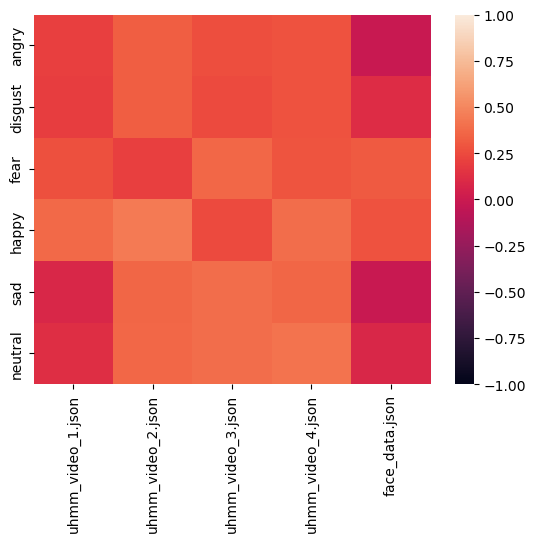

<IPython.core.display.Javascript object>

In [52]:
sns.heatmap(
    mean_corr_df, vmin=-1, vmax=1,
)

In [47]:
mean_corr_df.mean(axis=0)

uhmm_video_1.json    0.205432
uhmm_video_2.json    0.334414
uhmm_video_3.json    0.315523
uhmm_video_4.json    0.332649
face_data.json       0.126121
dtype: float64

<IPython.core.display.Javascript object>

#### Shifted correlation

In [53]:
mean_shifted_corr_df = pd.DataFrame(
    [
        emotions_df_dict[emotion].corr(method=shifted_corr).mean()
        for emotion in emotions
    ],
    index=emotions,
)
mean_shifted_corr_df

,uhmm_video_1.json,uhmm_video_2.json,uhmm_video_3.json,uhmm_video_4.json,face_data.json
angry,0.332128,0.382309,0.425769,0.402304,0.113827
disgust,0.386106,0.505962,0.380892,0.425796,0.241990
fear,0.521572,0.384976,0.531038,0.452246,0.397698
happy,0.481225,0.549750,0.445038,0.477168,0.327383
sad,0.246677,0.463666,0.448038,0.485980,0.230186
neutral,0.299515,0.418397,0.511975,0.523936,0.289345


<IPython.core.display.Javascript object>

<Axes: >

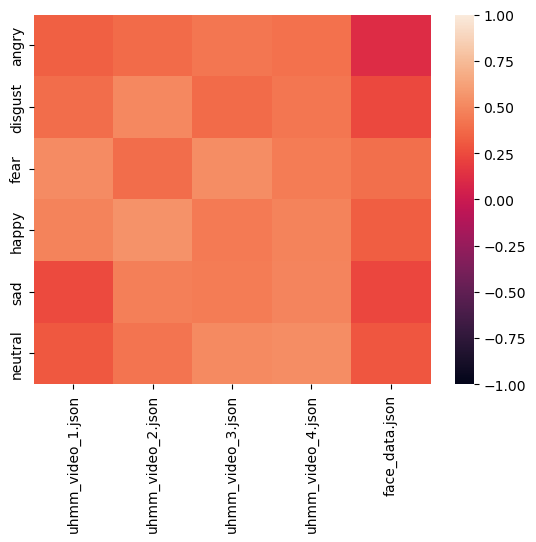

<IPython.core.display.Javascript object>

In [56]:
sns.heatmap(
    mean_shifted_corr_df, vmin=-1, vmax=1,
)

In [55]:
mean_shifted_corr_df.mean(axis=0)

uhmm_video_1.json    0.377870
uhmm_video_2.json    0.450843
uhmm_video_3.json    0.457125
uhmm_video_4.json    0.461238
face_data.json       0.266738
dtype: float64

<IPython.core.display.Javascript object>

### Analyze single metric 

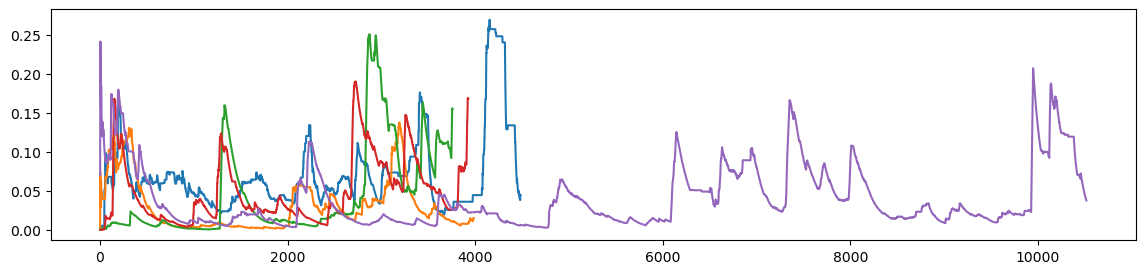

<IPython.core.display.Javascript object>

In [14]:
output_metric(
    metric=[target_metric], dfs=face_data_signals, smooth_span=smoothing_window
)

In [15]:
attr_merged_df = merge_on_metric(
    face_data_signals=face_data_signals,
    attr_name=target_metric,
    column_names=data_files,
    smoothing_window=smoothing_window,
    min_len=min_len,
)

<IPython.core.display.Javascript object>

<Axes: >

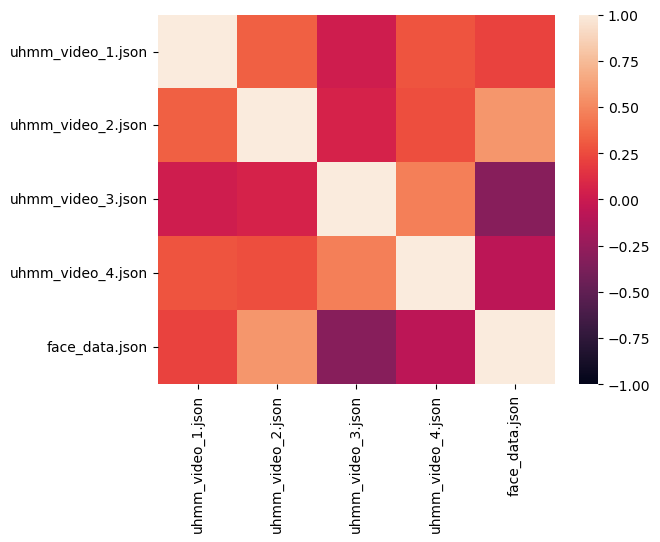

<IPython.core.display.Javascript object>

In [16]:
straight_corr = attr_merged_df.corr()
sns.heatmap(
    straight_corr, vmin=-1, vmax=1,
)

In [17]:
straight_corr

,uhmm_video_1.json,uhmm_video_2.json,uhmm_video_3.json,uhmm_video_4.json,face_data.json
uhmm_video_1.json,1.000000,0.333720,0.016548,0.285378,0.214856
uhmm_video_2.json,0.333720,1.000000,0.055130,0.263313,0.566168
uhmm_video_3.json,0.016548,0.055130,1.000000,0.467160,-0.314532
uhmm_video_4.json,0.285378,0.263313,0.467160,1.000000,-0.072963
face_data.json,0.214856,0.566168,-0.314532,-0.072963,1.000000


<IPython.core.display.Javascript object>

In [18]:
straight_corr.mean()

uhmm_video_1.json    0.370100
uhmm_video_2.json    0.443666
uhmm_video_3.json    0.244861
uhmm_video_4.json    0.388578
face_data.json       0.278706
dtype: float64

<IPython.core.display.Javascript object>

<Axes: >

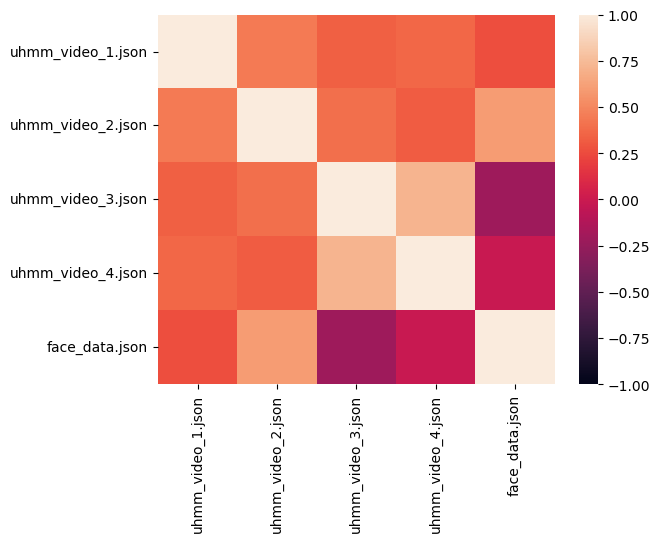

<IPython.core.display.Javascript object>

In [19]:
window_corr = attr_merged_df.corr(method=shifted_corr)
sns.heatmap(
    window_corr, vmin=-1, vmax=1,
)

In [20]:
window_corr

,uhmm_video_1.json,uhmm_video_2.json,uhmm_video_3.json,uhmm_video_4.json,face_data.json
uhmm_video_1.json,1.000000,0.443101,0.334642,0.363992,0.264389
uhmm_video_2.json,0.443101,1.000000,0.390977,0.315290,0.599381
uhmm_video_3.json,0.334642,0.390977,1.000000,0.716492,-0.216920
uhmm_video_4.json,0.363992,0.315290,0.716492,1.000000,-0.009936
face_data.json,0.264389,0.599381,-0.216920,-0.009936,1.000000


<IPython.core.display.Javascript object>

In [21]:
window_corr.mean()

uhmm_video_1.json    0.481225
uhmm_video_2.json    0.549750
uhmm_video_3.json    0.445038
uhmm_video_4.json    0.477168
face_data.json       0.327383
dtype: float64

<IPython.core.display.Javascript object>

## Pair by pair examination

In [22]:
def plot_pairwise_analysis(data, smoothing_span):
    plots_num = 5
    f, ax = plt.subplots(plots_num, 1, figsize=(14, 3 * plots_num))

    ax[0].plot(data)
    #     ax[0].set_ylim([0, 1])

    ax[1].plot(data.ewm(span=smoothing_span).mean())
    #     ax[1].set_ylim([0, 1])

    rolling_r = (
        data.iloc[:, 0]
        .rolling(window=smoothing_window, center=True)
        .corr(data.iloc[:, 1])
    )
    ax[2].set_ylim([-1, 1])
    ax[2].plot(rolling_r)

    rs, shift_ranges = get_shifted_correlations(
        data_1=data.iloc[:, 0], data_2=data.iloc[:, 1], shift_window=smoothing_span,
    )
    max_corr_shift = shift_ranges[np.argmax(rs)]
    ax[3].set_ylim([-1, 1])
    ax[3].plot(shift_ranges, rs)
    ax[3].axvline(0, color="k", linestyle="--", label="Center")
    ax[3].axvline(max_corr_shift, color="r", linestyle="--", label="Peak synchrony")

    ax[4].plot()
    #     ax[4].set_ylim([0, 1])
    data.iloc[:, 0].plot()
    data.iloc[:, 1].shift(max_corr_shift).plot()

    plt.legend()

<IPython.core.display.Javascript object>

In [23]:
attr1 = "uhmm_video_1.json"
attr2 = "uhmm_video_2.json"
metric = target_metric

<IPython.core.display.Javascript object>

In [24]:
metric_pair_merged_df = merge_on_metric(
    face_data_signals=face_data_signals,
    attr_name=metric,
    column_names=data_files,
    smoothing_window=smoothing_window,
    min_len=min_len,
)[[attr1, attr2]]
metric_pair_merged_df.head()

,uhmm_video_1.json,uhmm_video_2.json
0,NaN,0.000000
1,NaN,0.000000
2,NaN,0.073823
3,NaN,0.055182
4,0.0,0.046025


<IPython.core.display.Javascript object>

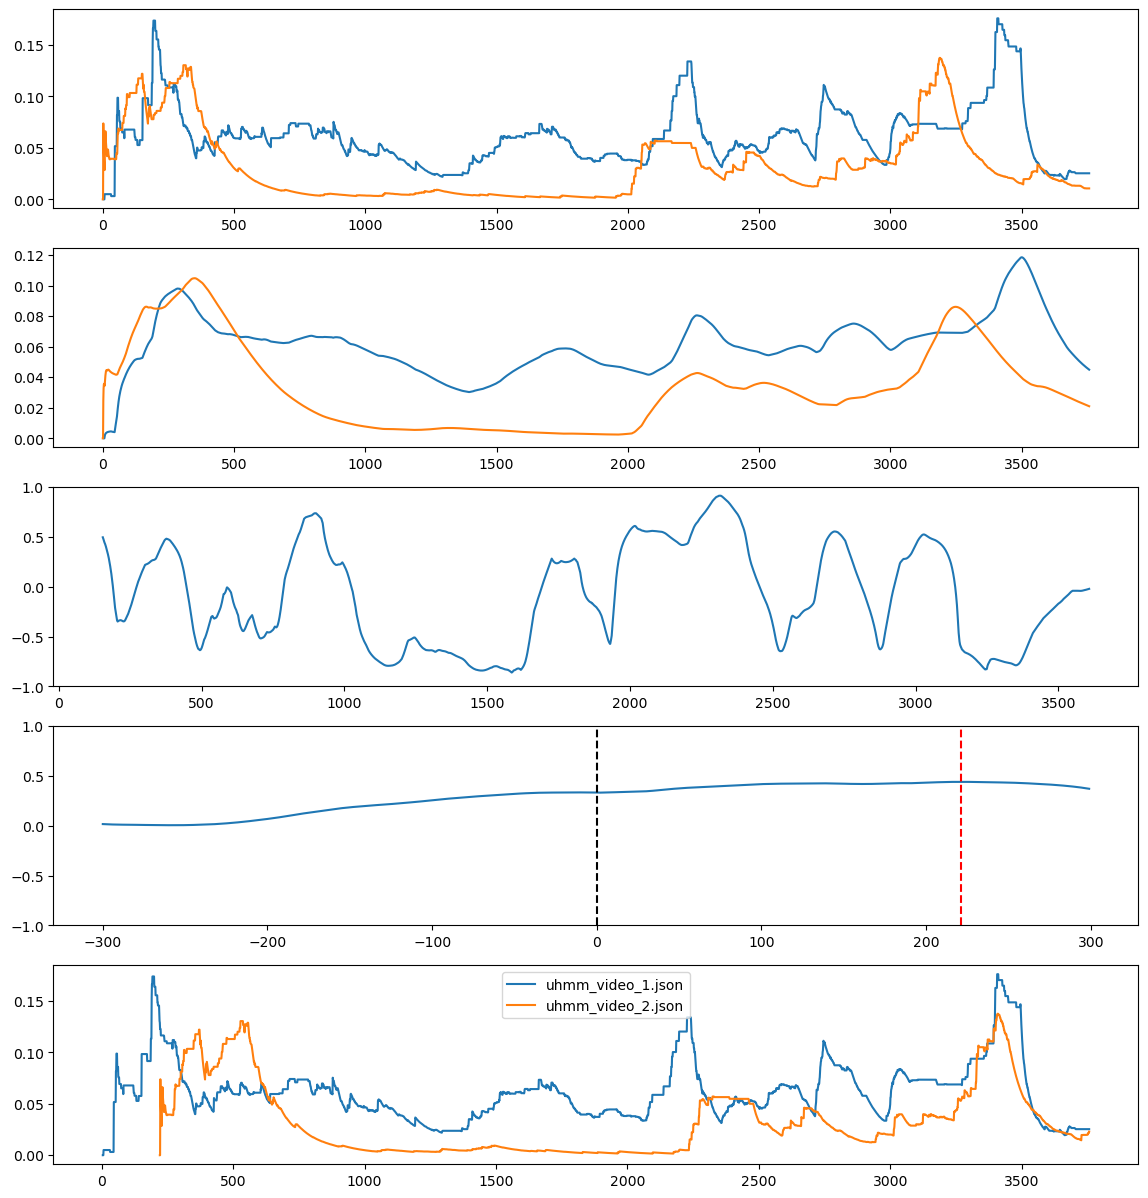

<IPython.core.display.Javascript object>

In [25]:
plot_pairwise_analysis(data=metric_pair_merged_df, smoothing_span=smoothing_window)